In [1]:
# Set OpenMP env early to avoid libiomp5md.dll conflict (PyTorch/NumPy/MKL)
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")

c_from_inversecm_to_MHz = 29979.2458


location = 'DAQ'
data_folder = r'\20221029'
if location == 'laptop':
    code_path = r'D:\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Code\Data_Analysis\Analysis_Code'
    #code_path = r'E:\Code\Data Analysis\Analysis_Code'
    #code_path = r'C:\Users\Arian\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\NickPilgram\Code\Data Analysis\Analysis_Code'
    path = r'D:\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
    #path = r'E:\Data\OrangeBeamBox\20200624'
elif location == 'home':
    code_path = r'C:\Users\Yuiki Takahashi\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\Yuiki Takahashi\Spinprecession\Spin_precession_try'
    path = r'C:\Users\Yuiki Takahashi\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
elif location == 'DAQ':
    code_path = r'F:\Hutzler Lab Dropbox\HutzlerLabShared\Personal\Yuiki Takahashi\Spinprecession\Spin_precession_try'
    path = r'F:\Hutzler Lab Dropbox\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
elif location == 'work':
    code_path = r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Code\Data_Analysis\Analysis_Code'
    path = r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabData\Orange Beam Source\PXI Data'
    path+=data_folder
print(path)

%matplotlib inline
import json
import ujson as uj
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append(code_path)
#import fit_functions as f
import pathlib
import datetime
from copy import deepcopy
version = 4
import math
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
#from joblib import Parallel, delayed
from scipy.ndimage import uniform_filter1d
import itertools
import argparse
import sys
#import joblib.parallel
from scipy.stats import uniform
from numpy import random, linalg
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special
import csv 
from scipy.signal import butter, sosfiltfilt, sosfreqz
import bisect
#from sigfig import round
import pandas as pd
from operator import itemgetter
#import data_analysis_functions_v2 as d2
from scipy.integrate import quad
from scipy.misc import derivative as driv
from scipy.special import j0
from scipy.special import j1
from scipy.special import jv
from scipy.special import dawsn
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.integrate import cumtrapz
from random import randint
from numpy.random import choice
import scipy.stats as st
import lmfit
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.backends.backend_pdf import PdfPages


F:\Hutzler Lab Dropbox\HutzlerLabData\Orange Beam Source\PXI Data\20221029


In [2]:
def get_raw_data_run(run_name,path,start = None,stop=None,save_raw = False, save_path = None,ujson=False):
    if start is None:
        start = 1
    if stop is None:
        file_nums = np.arange(start,d2.find_last_file(path,run_name))
    else:
        file_nums = np.arange(start,stop+1)
    print(run_name)
    raw_data, meta_data = d2.read_raw_data_array(file_nums,run_name,path,map_version='map',chunksize=2)
    print('Finished reading raw data')
    
    if save_raw:
        if run_name[-1] == '_':
            run_name = run_name[:-1]
        if save_path is None:
            data_file_path = 'raw_'+run_name
            meta_file_path = 'meta_'+run_name
        else:
            data_file_path = save_path+'_raw'
            meta_file_path = save_path+'_meta'
        save_json_data(raw_data,data_file_path,ujson=ujson)
        save_json_data(meta_data,meta_file_path,ujson=ujson)
    return raw_data,meta_data

def process_raw_data(raw_data,meta_data,ch_types = None,N_cmd=1,laser=None,num_avg=0, cycle_avg=False):
#     if N_cmd>1:
    all_raw_data = {}
    sorted_dict = d2.sort_by_command(raw_data,meta_data)
    for N in range(1,N_cmd+1):
        all_raw_data[N] = sorted_dict['waveform{:0>3d}'.format(N)]
    final_data = deepcopy(all_raw_data)
    for cmd_waveform in all_raw_data.keys():
        if laser is not None:
            final_data[cmd_waveform][-1] = d2.correct_freq(final_data[cmd_waveform][-1],laser=laser)
        if num_avg>0:
            final_data[cmd_waveform] = d2.average_raw_data_array(*final_data[cmd_waveform],num_avg=num_avg,cycle_avg=cycle_avg)
        final_data[cmd_waveform] = d2.process_raw_data_array(*final_data[cmd_waveform],ch_types)
#     elif N_cmd==1:
#         final_data=deepcopy([raw_data, meta_data])
#         if laser is not None:
#             final_data[-1] = d2.correct_freq(final_data[-1],laser=laser)
#         if num_avg>0:
#             final_data = d2.average_raw_data_array(*final_data,num_avg=num_avg,cycle_avg=cycle_avg)
#         final_data = d2.process_raw_data_array(*final_data,ch_types)
    return final_data

def get_json_data(file_path,numpy=False,ujson=False):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=False):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)
    
def smooth(y,N,sigma=0.4): #Implements a Gaussian convolution filter with N = width in indices and sigma = stdev normalized by N
    n=np.arange(N)
    gaussian = np.exp(-1/2*((n-N/2)/(sigma*N/2))**2)
    y_smooth = np.convolve(y, gaussian/gaussian.sum(), mode='valid')
    return y_smooth

def smooth_box(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def import_multiple_runs(scan_numbers,name='scan',read_existing=False):
    all_fluor = []
    all_front = []
    fluor_norm = []
    all_data = {}
    for n in scan_numbers:
        scan = '{}_{}'.format(name,n)
        if read_existing:
            raw_name = '{}_{}_raw'.format(data_folder[1:],scan)
            print(raw_name)
            meta_name = '{}_{}_meta'.format(data_folder[1:],scan)
            print(meta_name)
            raw = get_json_data(raw_name,numpy=True,ujson=True)
            meta = get_json_data(meta_name,numpy=False,ujson=True)
        else:
             raw,meta = get_raw_data_run(scan+'_',path,start = 5,stop=None,save_path=r'{}_{}'.format(data_folder[1:],scan),save_raw = True,ujson=True)
        all_data[n] = [raw,meta]
    return all_data

def analyze_data(all_data,avg=0,N_cmd=1,int_bounds=[(0.3,4.5),(0.3,6),(1.2,8)],plot=True):
    fluor_norm_b = []
    fluor_norm_u = []
    for run,data in all_data.items():
        raw,meta = data
        proc_data = process_raw_data(raw,meta,cycle_avg=False,num_avg=avg,N_cmd=N_cmd)
        print(proc_data[1][0].shape[0])
        int_data_u = d2.integrate_data_array(proc_data[1][0],proc_data[1][1],int_bounds,plot=plot)
        int_data_b = d2.integrate_data_array(*proc_data[2],int_bounds,plot=plot)
        fluor_norm_u.append([(int_data_u[2]/int_data_u[1]).mean(),(int_data_u[2]/int_data_u[1]).std()])
        fluor_norm_b.append([(int_data_b[2]/int_data_b[1]).mean(),(int_data_b[2]/int_data_b[1]).std()])
        #all_fluor.append([int_data[2].mean(),int_data[2].std()])
        #all_front.append([int_data[1].mean(),int_data[1].std()])
    return np.array(fluor_norm_u).T,np.array(fluor_norm_b).T

def sort_data(indep_var,depend_var,return_IV=True):
    #print(len(indep_var))
    #print(len(depend_var))
    if len(indep_var) != len(depend_var):
        print('Number of independent and dependent variables do not match')
    else:
        if not isinstance(indep_var,list):
            indep_var = list(indep_var)
        sorted_DV = [DV for IV,DV in sorted(zip(indep_var,depend_var))]
        if return_IV:
            sorted_IV = sorted(indep_var)
            return [np.array(sorted_IV),np.array(sorted_DV)]
        else:
            return np.array(sorted_DV)
        

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    sos = butter(order, low, analog=False, btype='lowpass', output='sos')
    return sos

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def line_func(x, a, b): 
    return x*a+b

def sine_func(t, A, w, p, c):  
    return A * np.sin(w*t + p) + c

def sine_line_func(t, A, w, p, c, a):  
    return A * np.sin(w*t + p) + t*a + c

In [3]:
# ---- X010_173 ground state setup (from 173_prediction_Feb2026 cell 4) ----
# Ensure Energy_Levels_old is importable from repo
import sys
import pathlib
_repo = pathlib.Path().resolve()
if str(_repo) not in sys.path:
    sys.path.insert(0, str(_repo))

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels

# Create X010_173 state (YbOH 173 isotope, X010 vibronic state)
X010_173 = MoleculeLevels.initialize_state(
    "YbOH", "173", "X010",
    [1, 2], M_values="all", I=[5/2, 1/2], S=1/2, round=8, P_values=[1/2, 3/2]
)
BASE_PARAMS_X010 = deepcopy(X010_173.parameters)

# Map Fitting lmfit param names (create_params_dict) to X010 param names
FIT_TO_X010_MAP = {
    'Be': 'Be',
    'Gamma_SR': 'Gamma_SR',
    'Gamma_prime': 'Gamma_Prime',
    'bF': 'bFYb',
    'c': 'cYb',
    'q_G': 'q_lD',
    'p_G+2q_G': 'p_lD',
    'e^2Q_q0': 'e2Qq0',
}

def set_state_parameters(state, updates=None):
    """Update state params and recompute eigensystem (from 173_prediction)."""
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)
    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params
    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers, params=new_params,
        M_values=state.M_values, precision=state.round,
    )
    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)


# Fixed excited state structure: each row = [N, J, F, Parity, state position in energy (cm^-1)]
All_excited_states_assignments = [
    [1, 0.5, 2, 1, 17651.459810673736],
    [1, 0.5, 3, 1, 17651.468732601665],
    [1, 0.5, 2, -1, 17651.47531461785],
    [1, 0.5, 3, -1, 17651.484772843334],
    [1, 1.5, 4, -1, 17651.851058394142],
    [1, 1.5, 3, -1, 17651.860713049806],
    [1, 1.5, 4, 1, 17651.866951578595],
    [1, 1.5, 2, -1, 17651.869167705463],
    [1, 1.5, 1, -1, 17651.874367705463],
    [1, 1.5, 3, 1, 17651.87647912011],
    [1, 1.5, 2, 1, 17651.88533753238],
    [1, 1.5, 1, 1, 17651.890233326245],
    [2, 1.5, 1, -1, 17652.624167705464],
    [2, 1.5, 2, -1, 17652.6279130498],
    [2, 1.5, 3, -1, 17652.6319130498],
    [2, 1.5, 4, -1, 17652.63665839414],
    [2, 1.5, 4, 1, 17652.654017886474],
]


def compute_ground_energy(p, ground_state_dict, isotope):
    """
    Compute ground state energy (cm^-1) from fit params and ground state quantum numbers.
    Uses X010_173 (Energy_Levels_old) with params mapped from lmfit. Structure from 173_prediction cell 4.
    Args: p (lmfit params), ground_state_dict {'N','G','F','Parity'}, isotope
    Returns: energy in cm^-1 (Torg + rotational/hyperfine splitting)
    """
    if str(isotope) != '173':
        raise ValueError("compute_ground_energy with X010_173 expects isotope=173")
    ground_state_params, _, _, _ = unpack_fit_params(p)
    x010_updates = dict(BASE_PARAMS_X010)
    for fit_key, x010_key in FIT_TO_X010_MAP.items():
        if fit_key in ground_state_params:
            x010_updates[x010_key] = ground_state_params[fit_key]
    for k in ['bFH', 'cH', 'muE', 'g_S_eff']:
        if k not in x010_updates and k in BASE_PARAMS_X010:
            x010_updates[k] = BASE_PARAMS_X010[k]
    set_state_parameters(X010_173, x010_updates)
    evals, evecs = X010_173.evals0, X010_173.evecs0
    parities = np.array(X010_173.parities)
    indices = X010_173.select_q({'N': ground_state_dict['N']})
    if len(indices) == 0:
        raise ValueError(f"No ground state with N={ground_state_dict['N']} found")
    q = X010_173.q_numbers
    N_tgt, G_tgt, F_tgt, P_tgt = ground_state_dict['N'], ground_state_dict['G'], ground_state_dict['F'], ground_state_dict['Parity']
    # In this notebook, Assignments use F to mean F1 (as in 173_prediction). Match G->G, F->F1 exactly.
    for idx in indices:
        maxidx = np.argmax(evecs[idx]**2)
        G_val = float(np.asarray(q['G'])[maxidx])
        F1_val = float(np.asarray(q['F1'])[maxidx])  # F in Assignments = F1 in X010
        parity_val = int(np.sign(parities[idx])) if idx < len(parities) else 0
        if G_val == G_tgt and F1_val == F_tgt and parity_val == P_tgt:
            E_MHz = float(evals[idx])
            E_cm1 = E_MHz / c_from_inversecm_to_MHz
            Torg = ground_state_params.get('Torg', 0) or 0
            return E_cm1 + Torg
    raise ValueError(f"No ground state matching {ground_state_dict} in X010_173")


def compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope):
    """
    Produce predicted transitions using All_excited_states_assignments for excited state energies
    and compute_ground_energy_fn for ground state energies. No Molecular_State.
    Returns: (Transitions, frequencies_list, intensities_list)
    """
    Transitions = []
    for assignment in Assignments:
        ground_dict = assignment['ground state']
        excited_dict = assignment['excited state']
        match = None
        for row in All_excited_states_assignments:
            N_e, J_e, F_e, Parity_e = row[0], row[1], row[2], row[3]
            if (J_e == excited_dict['J'] and F_e == excited_dict['F'] 
                and Parity_e == excited_dict['Parity']):
                match = row
                break
        if match is not None:
            E_excited_cm1 = match[4]
            E_ground_cm1 = compute_ground_energy_fn(p, ground_dict, isotope)
            freq_cm1 = E_excited_cm1 - E_ground_cm1
            freq_MHz = freq_cm1 * c_from_inversecm_to_MHz
            Transitions.append({
                'ground state': ground_dict,
                'excited state': excited_dict,
                'freq': freq_MHz
            })
    frequencies = [t['freq'] for t in Transitions]
    intensities = [1.0] * len(Transitions)
    return Transitions, frequencies, intensities


def Spectrum_residuals(Lines,Pred, uncertainty_array):
    
    res=[]
    
    n = 0
    
    #print(Pred)
    
    for i in range(len(Lines)):
        found = False
        N_g_data=Lines[i]['ground state']['N']
        G_g_data=Lines[i]['ground state']['G']
        F_g_data=Lines[i]['ground state']['F']
        Parity_g_data=Lines[i]['ground state']['Parity']
        J_e_data=Lines[i]['excited state']['J']
        P_e_data=Lines[i]['excited state']['P']
        F_e_data=Lines[i]['excited state']['F']
        Parity_e_data=Lines[i]['excited state']['Parity']
        for j in range(len(Pred)):
            N_g_pred=Pred[j]['ground state']['N']
            G_g_pred=Pred[j]['ground state']['G']
            F_g_pred=Pred[j]['ground state']['F']
            Parity_g_pred=Pred[j]['ground state']['Parity']
            J_e_pred=Pred[j]['excited state']['J']
            P_e_pred=Pred[j]['excited state']['P']
            F_e_pred=Pred[j]['excited state']['F']
            Parity_e_pred=Pred[j]['excited state']['Parity']
            
            if N_g_data==N_g_pred and G_g_data==G_g_pred and F_g_data==F_g_pred and Parity_g_data==Parity_g_pred and J_e_data==J_e_pred and Parity_e_data==Parity_e_pred and P_e_data==P_e_pred and F_e_data==F_e_pred:
                
                if uncertainty_array is None:
                    res.append(Lines[i]['freq']-Pred[j]['freq'])
                else:
                    res.append( (Lines[i]['freq']-Pred[j]['freq']) / uncertainty_array[i] )

                n += 1
                
                found = True
        if found:
            found = False
        else:
            print('The line cannot be found..  freq: ',Lines[i]['freq'])


                
    return res



def create_params_dict():
    
    params_dict={
        'Torg_g':['ground state','Torg','Torg'],
        'Be_g':['ground state', 'Be', 'Rotation'],
        'Gamma_SR_g':['ground state','Gamma_SR','Spin Rotation'],
        'Gamma_prime_g':['ground state','Gamma_prime','Spin Rotation gamma prime'],
        'ASO_g': ['ground_state', 'ASO','Spin Orbit'],
        'p2q_g': ['ground state','p+2q','Lambda Doubling'],
        'qG_g': ['ground state','q_G','l Doubling qG'],
        'pG2qG_g': ['ground state','p_G+2q_G','l Doubling pG plus 2qG'],
        'D_g': ['ground state','D', 'Centrifugal Distortion'],
        'GammaD_g': ['ground state','GammaD', 'Spin Rotation CD'],
        'p2qD_g': ['ground state','(p+2q)D','Lambda Doubling CD'],
        'bF_g': ['ground state','bF','Fermi Contact'],
        'c_g': ['ground state','c','HF Dipole Dipole'],
        'ew2_g' : ['ground state','ew2', 'Renner Teller'],
        'gk_g' : ['ground state','gk','Renner Teller gk'],
        'epsilonaa_g' : ['ground state','gamma g epsilon aa','Epsilon aa'],
        'pG_g': ['ground state','p_G','l Doubling pG'],
        'e2Qq0_g': ['ground state','e^2Q_q0','Quadrupole term'],

        'Torg_e':['excited state','Torg','Torg'],
        'Be_e':['excited state', 'Be', 'Rotation'],
        'Gamma_SR_e':['excited state','Gamma_SR','Spin Rotation'],
        'Gamma_prime_e':['excited state','Gamma_prime','Spin Rotation gamma prime'],
        'ASO_e': ['excited state', 'ASO','Spin Orbit'],
        'p2q_e': ['excited state','p+2q','Lambda Doubling'],
        'qG_e': ['excited state','q_G','l Doubling qG'],
        'pG2qG_e': ['excited state','p_G+2q_G','l Doubling pG plus 2qG'],
        'D_e': ['excited state','D', 'Centrifugal Distortion'],
        'GammaD_e': ['excited state','GammaD', 'Spin Rotation CD'],
        'p2qD_e': ['excited state','(p+2q)D','Lambda Doubling CD'],
        'bF_e': ['excited state','bF','Fermi Contact'],
        'c_e': ['excited state','c','HF Dipole Dipole'],
        'ew2_e' : ['excited state','ew2', 'Renner Teller'],
        'gk_e' : ['excited state','gk','Renner Teller gk'],
        'a_e': ['excited state','a','HF a term'],
        'd_e': ['excited state','d','HF d term'],
        'e2Qq0_e': ['excited state','e^2Q_q0','Quadrupole term']
        
        
    }
    
    return params_dict


def create_fit_parameters(params_g,params_e):
    
    p = lmfit.Parameters()
    
    for i in params_g:
        if params_g[i][1]=='float':
            vary_val=True
        elif params_g[i][1]=='fix':
            vary_val=False
        p.add(i+'{}'.format('_g'),value=params_g[i][0],vary=vary_val)
        
    for j in params_e:
        if params_e[j][1]=='float':
            vary_val=True
        elif params_e[j][1]=='fix':
            vary_val=False
        p.add(j+'{}'.format('_e'),value=params_e[j][0],vary=vary_val)
    
    
    return p

def unpack_fit_params(p):
    
    params_dict=create_params_dict()
    
    ground_state_params={}
    ground_state_H_keys=[]
    excited_state_params={}
    excited_state_H_keys=[]
    
    for i in p.valuesdict():
        if params_dict[i][0]=='ground state':
            ground_state_params[params_dict[i][1]]=p.valuesdict()[i]
            if params_dict[i][1]!='Torg':
                ground_state_H_keys.append(params_dict[i][2])
        elif params_dict[i][0]=='excited state':
            excited_state_params[params_dict[i][1]]=p.valuesdict()[i]
            if params_dict[i][1]!='Torg':
                excited_state_H_keys.append(params_dict[i][2])
            
    return ground_state_params,ground_state_H_keys,excited_state_params,excited_state_H_keys


                                 
def spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn=None):
    """
    No Molecular_State. Uses All_excited_states_assignments for excited state.
    compute_ground_energy_fn(p, ground_dict, isotope) -> energy_cm1 must be provided.
    """
    if compute_ground_energy_fn is None:
        raise ValueError("compute_ground_energy_fn is required. Implement when ground state structure is provided.")
    Transitions, _, _ = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    return Spectrum_residuals(Assignments, Transitions, uncertainty_array)


def fit_spectrum(p, Assignments, All_excited_states_assignments, Temp, compute_ground_energy_fn, uncertainty_array = None, isotope = 174, plot_res=True, error_estimation=False, TDM_type  = 'aBJ No M Yuiki'):
    
    if uncertainty_array is not None:
        if len(Assignments) != len(uncertainty_array):
            print('The length of Assignments array must be the same as uncertainty array!')
    
    # Pre-check: need enough residuals (>= varying params) for leastsq
    n_vary = sum(1 for v in p.values() if getattr(v, 'vary', True))
    initial_res = spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn)
    n_res = len(initial_res)
    if n_res < n_vary:
        n_unmatched = len(Assignments) - n_res
        raise ValueError(
            f"Only {n_res} lines matched (need >= {n_vary} for {n_vary} varying parameters). "
            f"{n_unmatched} assignment(s) have no matching excited state in All_excited_states_assignments. "
            "Check that each assignment's excited state (J, F, Parity) exists in All_excited_states_assignments, "
            "or add more Assignments, or fix some parameters."
        )
    
    fcn_args = (Assignments, All_excited_states_assignments, Temp, uncertainty_array, isotope, TDM_type, compute_ground_energy_fn)
    mini = lmfit.Minimizer(spectrum_residuals_lmfit, p, fcn_args=fcn_args, nan_policy='omit')

    result = mini.minimize(method='leastsq')

    print(lmfit.report_fit(result.params))
    print('')
    print('reduced chi squared: ', result.redchi)
    
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))
        
    post_fit_res = spectrum_residuals_lmfit(result.params, Assignments, All_excited_states_assignments, Temp, None, isotope, TDM_type, compute_ground_energy_fn)
        
    if plot_res==True:
        plt.figure(1,figsize=(15,8))
        zero_plot=np.zeros(len(Assignments))
        plt.plot(spectrum_residuals_lmfit(p, Assignments, All_excited_states_assignments, Temp, None, isotope, TDM_type, compute_ground_energy_fn),'o',label='before fit')
        plt.plot(post_fit_res,'s',label='after fit')
        plt.plot(zero_plot)
        plt.title('Residuals',fontsize=18)
        plt.legend(loc='best')
        
    print('fit residuals standard deviation',np.std(post_fit_res))
    
    return result


def examine_residuals(p, Assignments, All_excited_states_assignments, Temp, compute_ground_energy_fn, print_output=True, isotope = 174, TDM_type = 'aBJ No M Chi'):
    
    spec_pred, _, _ = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    
    res_data=[]
    
    for i in range(len(Assignments)):
        N_g_data=Assignments[i]['ground state']['N']
        G_g_data=Assignments[i]['ground state']['G']
        F_g_data=Assignments[i]['ground state']['F']
        Parity_g_data=Assignments[i]['ground state']['Parity']
        J_e_data=Assignments[i]['excited state']['J']
        F_e_data=Assignments[i]['excited state']['F']        
        P_e_data=Assignments[i]['excited state']['P']
        Parity_e_data=Assignments[i]['excited state']['Parity']
        for j in range(len(spec_pred)):
            N_g_pred=spec_pred[j]['ground state']['N']
            G_g_pred=spec_pred[j]['ground state']['G']
            F_g_pred=spec_pred[j]['ground state']['F']
            Parity_g_pred=spec_pred[j]['ground state']['Parity']
            J_e_pred=spec_pred[j]['excited state']['J']
            P_e_pred=spec_pred[j]['excited state']['P']
            F_e_pred=spec_pred[j]['excited state']['F']
            Parity_e_pred=spec_pred[j]['excited state']['Parity']
            
            if N_g_data==N_g_pred and Parity_g_data==Parity_g_pred and J_e_data==J_e_pred and Parity_e_data==Parity_e_pred and G_g_data==G_g_pred and F_g_data==F_g_pred and P_e_data==P_e_pred and F_e_data==F_e_pred:
                res_data.append({'Line':Assignments[i]['freq'],
                                 'Residual':Assignments[i]['freq']-spec_pred[j]['freq'],
                                 'ground state':Assignments[i]['ground state'],
                                 'excited state':Assignments[i]['excited state']})
    
    if print_output==True:
        for k in range(len(res_data)):
            print(res_data[k])
            print('\n')
    
    return res_data




def predict_FM_spectrum(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, theta, width, freq_range, isotope=174):
    """No Molecular_State. Uses compute_transitions."""
    Transitions, frequencies, intensities = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    centers = [f for f in frequencies if freq_range[0] < f < freq_range[1]]
    heights = [intensities[i] for i, f in enumerate(frequencies) if freq_range[0] < f < freq_range[1]]
    widths = [width] * len(centers)
    w = np.arange(freq_range[0], freq_range[1], 0.00005)
    I = I_FM(w, centers, widths, heights, theta)
    Q = Q_FM(w, centers, widths, heights, theta)
    return w, I, Q

def predict_Gaussian_spectrum(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, width, freq_range, isotope=174):
    """No Molecular_State. Uses compute_transitions."""
    Transitions, frequencies, intensities = compute_transitions(p, Assignments, All_excited_states_assignments, compute_ground_energy_fn, isotope)
    centers = [f for f in frequencies if freq_range[0] < f < freq_range[1]]
    heights = [intensities[i] for i, f in enumerate(frequencies) if freq_range[0] < f < freq_range[1]]
    widths = [width] * len(centers)
    w = np.arange(freq_range[0], freq_range[1], 0.00005)
    pred = mult_gaussian(w, centers, widths, heights)
    return w, pred


def gaussian(w,w0,Gamma,amp):
    return amp*np.exp((-1)*((w-w0)**2)/(2*((Gamma/2.355)**2)))

def mult_gaussian(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian(w,w0[i],Gamma[i],amp[i])
    return out

def gaussian_dispersion(w,w0,Gamma,amp):
    return (-2/np.sqrt(np.pi))*amp*dawsn((w-w0)/(np.sqrt(2)*(Gamma/2.355)))

def mult_gaussian_dispersion(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian_dispersion(w,w0[i],Gamma[i],amp[i])
    return out


wm=50.3*(3.34*10**(-5)) #cm^-1
M=0.84

def A_FM_2nd_order(w,w0,Gamma,amp):
    return ((j0(M)*j1(M)*(mult_gaussian(w-wm,w0,Gamma,amp)-mult_gaussian(w+wm,w0,Gamma,amp)))+
            (j1(M)*jv(2,M)*(mult_gaussian(w-2*wm,w0,Gamma,amp)-mult_gaussian(w+2*wm,w0,Gamma,amp)+
                            mult_gaussian(w-wm,w0,Gamma,amp)-mult_gaussian(w+wm,w0,Gamma,amp))))

def D_FM_2nd_order(w,w0,Gamma,amp):
    return ((j0(M)*j1(M)*(mult_gaussian_dispersion(w-wm,w0,Gamma,amp)+mult_gaussian_dispersion(w+wm,w0,Gamma,amp)-
                          2*mult_gaussian_dispersion(w,w0,Gamma,amp)))+
            (j1(M)*jv(2,M)*(mult_gaussian_dispersion(w-2*wm,w0,Gamma,amp)+mult_gaussian_dispersion(w+2*wm,w0,Gamma,amp)-
                           mult_gaussian_dispersion(w-wm,w0,Gamma,amp)-mult_gaussian_dispersion(w+wm,w0,Gamma,amp))))


# def I_FM(w,w0,Gamma,amp,theta,offset):
#     return np.cos(theta)*A_FM_2nd_order(w,w0,Gamma,amp)+np.sin(theta)*D_FM_2nd_order(w,w0,Gamma,amp)+offset

# def Q_FM(w,w0,Gamma,amp,theta,offset):
#     return np.sin(theta)*A_FM_2nd_order(w,w0,Gamma,amp)-np.cos(theta)*D_FM_2nd_order(w,w0,Gamma,amp)+offset


def I_FM(w,w0,Gamma,amp,theta):
    return np.cos(theta)*A_FM_2nd_order(w,w0,Gamma,amp)+np.sin(theta)*D_FM_2nd_order(w,w0,Gamma,amp)

def Q_FM(w,w0,Gamma,amp,theta):
    return np.sin(theta)*A_FM_2nd_order(w,w0,Gamma,amp)-np.cos(theta)*D_FM_2nd_order(w,w0,Gamma,amp)


                   

In [4]:
#global_Lorentzian_mode = False

def Set_Lorentzian_mode(Lorentzian_mode):
    global global_Lorentzian_mode
    global_Lorentzian_mode = Lorentzian_mode

    
# Note that Gamma here is a FWHM of lineshape!

def gaussian(w,w0,Gamma,amp):
    Lorentzian_mode = global_Lorentzian_mode
    if Lorentzian_mode:
        return amp * (Gamma/2)**2 / ( (Gamma/2)**2 + ( w - w0 )**2)
    else:
        return amp*np.exp((-1)*((w-w0)**2)/(2*((Gamma/2.355)**2)))

def mult_gaussian(w,w0,Gamma,amp):
    out=0
    for i in range(len(w0)):
        out=out+gaussian(w,w0[i],Gamma[i],amp[i],)
    return out

def Gaussian_forfit_lmfit(w,p):

    parvals = p.valuesdict()

    N=len(p)

    centers=np.zeros(int(N/3))
    widths=np.zeros(int(N/3))
    heights=np.zeros(int(N/3))
    for i in range(int(N/3)):
        centers[i]=parvals['center{}'.format(i)]
        widths[i]=parvals['width{}'.format(i)]
        heights[i]=parvals['height{}'.format(i)]

    return mult_gaussian(w,centers,widths,heights)

def Gaussian_res_lmfit(p,w,data):


    res=np.zeros(len(w))

    for i in range(len(w)):
        res[i] = Gaussian_forfit_lmfit(w[i],p)-data[i]


    return res



def Gaussian_fit_lmfit(p,w,data,plot=True,error_estimation=False):

    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]


    w2=w-w0

    mini = lmfit.Minimizer(Gaussian_res_lmfit, p, fcn_args=(w2, data),nan_policy='omit')

    result = mini.minimize(method='leastsq')

    print(lmfit.report_fit(result.params))

    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w2,data)
        plt.plot(w2,Gaussian_forfit_lmfit(w2,result.params))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w2,Gaussian_forfit_lmfit(w2,result.params)-data,'o')
        plt.plot(w2,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)


    N=len(fit_values)
    centers={}
    for i in range(int(N/3)):
        centers['true_center{}'.format(i)]=fit_values['center{}'.format(i)]+w0
        centers['error{}'.format(i)]=result.params['center{}'.format(i)].stderr
        centers['width{}'.format(i)]=result.params['width{}'.format(i)].value


    print(centers)



    return result,centers



def Gaussian_fit_lmfit_yuiki(p, p1, width_bound_sigma, w, data, plot=True, error_estimation=False, freq_lim = None, background_subtract = False, Lorentzian_mode = False, print_fit_properties = True):

    Set_Lorentzian_mode(Lorentzian_mode)
    
    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    w2=w-w0
    
    fit_centers = np.zeros(len(p1))
    fit_widths = np.zeros(len(p1))
    fit_heights = np.zeros(len(p1))
    caution_centers = []
    
    if background_subtract is not False:
        remove_index_for_background = [i for i , element in enumerate(w) if element > background_subtract[0] and element < background_subtract[1]]
        data_for_background = [element for i , element in enumerate(data) if i in remove_index_for_background]
        background = np.average(data_for_background)
        data -= background
    
    for a in range(len(p1)):
        if a+1 < len(p1):
            if p1[a][1] > p[a+1, 0, 0]:
                print('CAUTION! The peaks at ',  p[a, 0, 0]+w0, ' and',  p[a+1, 0, 0]+w0, ' cm-1 are within ', width_bound_sigma, ' sigma of the peak width (i.e. they are too close) and thus the peak fitting may not work! Do peak fitting manually for this region')
                caution_centers.append([p[a, 0, 0]+w0, p[a+1, 0, 0]+w0])
           
        remove_index = [i for i , element in enumerate(w2) if element > p1[a][0] and element < p1[a][1]]
        w2_small = [element for i , element in enumerate(w2) if i in remove_index]
        data_small = [element for i , element in enumerate(data) if i in remove_index]
                
        scale = 1.
        w2_small = scale*np.array(w2_small)
        p[a,0] *= scale
        p[a,1] *= scale
        
        
        para = lmfit.Parameters()
        para.add('center{}'.format(0),value=p[a,0,0],min=p[a,0,1],max=p[a,0,2])   #min=min(w)-w0,max=max(w)-w0)
        #x0[int(N/3)+1+i]=widths
        para.add('width{}'.format(0),value=p[a,1,0],min=p[a,1,1],max=p[a,1,2])
        #x0[int(2*N/3)+1+i]=I_data_smooth[peaks[i]]
        para.add('height{}'.format(0),value=p[a,2,0],min=p[a,2,1],max=p[a,2,2])
        

        mini = lmfit.Minimizer(Gaussian_res_lmfit, para, fcn_args=(w2_small, data_small),nan_policy='omit')
        result = mini.minimize(method='leastsq')
        if print_fit_properties:
            print(lmfit.report_fit(result.params))
        fit_values = result.params.valuesdict()
        fit_centers[a]=fit_values['center{}'.format(0)]/scale
        fit_widths[a]=fit_values['width{}'.format(0)]/scale
        fit_heights[a]=fit_values['height{}'.format(0)]
        p[a,0] /= scale
        p[a,1] /= scale
        
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    #fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w,data)
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights)-data,'o')
        plt.plot(w,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])
            
    print(fit_centers)





    return fit_centers+w0, fit_widths, fit_heights, caution_centers




def Gaussian_fit_lmfit_yuiki2(p, p1, width_bound_sigma, w, data, plot=True, error_estimation=False, freq_lim = None, background_subtract = False, Lorentzian_mode = False, print_fit_properties = True):

    Set_Lorentzian_mode(Lorentzian_mode)
    
    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    w2=w-w0
    
    peaks_identified = [p[:,0,0]+w0,p[:,2,0]]
    
    if background_subtract is not False:
        remove_index_for_background = [i for i , element in enumerate(w) if element > background_subtract[0] and element < background_subtract[1]]
        data_for_background = [element for i , element in enumerate(data) if i in remove_index_for_background]
        background = np.average(data_for_background)
        data -= background
    
    fit_centers = np.zeros(len(p1))
    fit_widths = np.zeros(len(p1))
    fit_heights = np.zeros(len(p1))
    fit_errors = np.zeros(len(p1))
    caution_centers = []
    already_fit_peaks = []
    cut_regions = []
    
    for a in range(len(p1)):

        
        if a in already_fit_peaks:
            already_fit = True
        else:
            already_fit = False
            already_fit_peaks = [a]
            
        if already_fit is False:
            upper_bound = p1[a][1]
            lower_bound = p1[a][0]
        
            if a+1 < len(p1):
                if p1[a][1] > p1[a+1][0]:
                    upper_bound = p1[a+1][1]
                    already_fit_peaks.append(a+1)
                    
                    if a+2 < len(p1):
                        if p1[a+1][1] > p1[a+2][0]:
                            upper_bound = p1[a+2][1]
                            already_fit_peaks.append(a+2)
                            
                            if a+3 < len(p1):
                                if p1[a+2][1] > p1[a+3][0]:
                                    upper_bound = p1[a+3][1]
                                    already_fit_peaks.append(a+3)
                                    
                                    if a+4 < len(p1):
                                        if p1[a+3][1] > p1[a+4][0]:
                                            upper_bound = p1[a+4][1]
                                            already_fit_peaks.append(a+4)
                                            
                                            if a+5 < len(p1):
                                                if p1[a+4][1] > p1[a+5][0]:
                                                    upper_bound = p1[a+5][1]
                                                    already_fit_peaks.append(a+5)
                                                    
                                                    if a+6 < len(p1):
                                                        if p1[a+5][1] > p1[a+6][0]:
                                                            upper_bound = p1[a+6][1]
                                                            already_fit_peaks.append(a+6)  
                                                            
                                                            if a+7 < len(p1):
                                                                if p1[a+6][1] > p1[a+7][0]:
                                                                    upper_bound = p1[a+7][1]
                                                                    already_fit_peaks.append(a+7)
                                                                    
                                                                    if a+8 < len(p1):
                                                                        if p1[a+7][1] > p1[a+8][0]:
                                                                            upper_bound = p1[a+8][1]
                                                                            already_fit_peaks.append(a+8)
                                                                            
                                                                            if a+9 < len(p1):
                                                                                if p1[a+8][1] > p1[a+9][0]:
                                                                                    upper_bound = p1[a+9][1]
                                                                                    already_fit_peaks.append(a+9)
                                                                                    
                                                                                    if a+10 < len(p1):
                                                                                        if p1[a+9][1] > p1[a+10][0]:
                                                                                            print('>10 peaks are too close within', width_bound_sigma, 'sigma of the peak width (i.e. very congested) Do peak fitting manually for this region')
                                                                                            caution_centers.append([p[a, 0, 0]+w0, p[a+1, 0, 0]+w0, p[a+2, 0, 0]+w0, p[a+3, 0, 0]+w0, p[a+4, 0, 0]+w0, p[a+5, 0, 0]+w0, p[a+6, 0, 0]+w0, p[a+7, 0, 0]+w0, p[a+8, 0, 0]+w0, p[a+9, 0, 0]+w0, p[a+10, 0, 0]+w0])
                                                    

            remove_index = [i for i , element in enumerate(w2) if element > lower_bound and element < upper_bound]
            w2_small = [element for i , element in enumerate(w2) if i in remove_index]
            data_small = [element for i , element in enumerate(data) if i in remove_index]

            para = lmfit.Parameters()
            
            ii = 0
            for b in already_fit_peaks:
                para.add('center{}'.format(ii),value=p[b,0,0],min=p[b,0,1],max=p[b,0,2])   #min=min(w)-w0,max=max(w)-w0)
                #x0[int(N/3)+1+i]=widths
                para.add('width{}'.format(ii),value=p[b,1,0],min=p[b,1,1],max=p[b,1,2])
                #x0[int(2*N/3)+1+i]=I_data_smooth[peaks[i]]
                para.add('height{}'.format(ii),value=p[b,2,0],min=p[b,2,1],max=p[b,2,2])
                ii += 1


            mini = lmfit.Minimizer(Gaussian_res_lmfit, para, fcn_args=(w2_small, data_small),nan_policy='omit')

            result = mini.minimize(method='leastsq')
            if print_fit_properties:
                print(lmfit.report_fit(result.params))
                
            iii = 0
            for b in already_fit_peaks:
                fit_values = result.params.valuesdict()
                fit_centers[b]=fit_values['center{}'.format(iii)]
                fit_widths[b]=fit_values['width{}'.format(iii)]
                fit_heights[b]=fit_values['height{}'.format(iii)]
                fit_errors[b]=result.params['center{}'.format(iii)].stderr
                iii += 1
                
            cut_regions.append([lower_bound+w0, upper_bound+w0, len(already_fit_peaks)])
        
    if error_estimation==True:

        ci, trace = lmfit.conf_interval(mini, result, sigmas=[1, 2], trace=True, verbose=False)
        print(lmfit.printfuncs.report_ci(ci))

    #fit_values = result.params.valuesdict()

    if plot==True:
        plt.figure(1,figsize=(15,8))
        plt.plot(w,data)
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights))
        plt.title('Data',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])



        plot_zero=np.zeros(len(w2))

        plt.figure(3,figsize=(15,8))
        plt.plot(w,mult_gaussian(w2,fit_centers,fit_widths,fit_heights)-data,'o')
        plt.plot(w,plot_zero)
        plt.title('Data Residuals',fontsize=12)
        plt.xlabel('Frequency (cm^-1)',fontsize=12)
        if freq_lim is not None:
            plt.xlim(freq_lim[0],freq_lim[1])
            
    #print(fit_centers)





    return fit_centers+w0, fit_widths, fit_heights, cut_regions, peaks_identified, caution_centers, fit_errors

In [5]:
def find_peaks_2(data,freq_data,threshold,data_range=[],add_peak=None):

    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13.75}

    matplotlib.rc('font', **font)

    freq_low=freq_data[int(len(freq_data)/10)]
    freq_high=freq_data[len(freq_data)-int(len(freq_data)/10)]
    if freq_high>freq_low:
        print('Frequency low to high')
    else:
        print('Frequency high to low')

    if len(data_range)==0:
        k = np.arange(0,len(data),1)
        a_nosmooth=np.array(data)
    else:
        k = np.arange(data_range[0],data_range[1],1)
        a_nosmooth=np.array(data[data_range[0]:data_range[1]])

    a_nosmooth = a_nosmooth * 100.0 / max(a_nosmooth)

    cs=interp1d(k,a_nosmooth)

    if len(data_range)==0:
        new_k=np.arange(0,len(data)-1,0.1)
    else:
        new_k = np.arange(data_range[0],data_range[1]-1,0.1)

    a = cs(new_k)

    # plt.figure(1,figsize=(15,8))
    # plt.plot(k,a_nosmooth)
    # plt.plot(new_k,a,'o')

    da = np.gradient(a)
    dda = np.gradient(da)

    peaks = []

    for i in range(len(a)-1):
        if da[i]>0 and da[i+1]<0 and dda[i] < 0 and a[i]>threshold:
            peaks.append(int(np.round(new_k[i])))

    if add_peak != None:
        for iii in range(len(add_peak)):
            peaks.append(add_peak[iii])

    peaks.sort()


    fig, ax = plt.subplots(figsize=(26, 13),dpi=150)
    matplotlib.rcParams.update({'font.size': 18})
    matplotlib.rcParams.update({'font.family': 'serif'})

    ax.plot(k, a_nosmooth)

    if len(data_range)==0:
        data_start=0
    else:
        data_start=data_range[0]
    plotline(peaks,k,a_nosmooth,ax,data_start)

    ax.grid(True)
    #ax.set_ylim([-5, 105])
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(.01))
    plt.show()

    return peaks


def plotline(peaks,k,a,ax,data_start):
    for i in range(len(peaks)):
#
        ax.vlines(peaks[i], 0, a[peaks[i]-data_start]+5, linestyle='-')
        ax.text(peaks[i]-.001,
                a[peaks[i]-data_start]+8, str(peaks[i]),
                fontsize=14, rotation=90, va='bottom')
        ax.text(peaks[i]-.001,
                -5, 'a'+str(i),
                fontsize=14, rotation=90)

def avg_mult(func,num_avg):
    if num_avg == 0:
        return func
    else:
        i = num_avg
        avg = avg_func(func)
        i-=1
        while i !=0:
            avg = avg_func(avg)
            i-=1
    return avg


def avg_func(func):
    avg = np.zeros(len(func))
    for i in range(len(func)):
        if i == 0:
            avg[i] = (func[i]+func[i+1])/2
        if i == len(func)-1:
            avg[i] = (func[i]+func[i-1])/2
        else:
            avg[i] = (func[i-1]+func[i]+func[i+1])/3
    return avg


def Find_Gaussian_initial_guess_lmfit(w,data,widths,Box=10,threshold=0.1,add_peak=None,width_bound_sigma=5):

    freq_low=w[int(len(w)/10)]
    freq_high=w[len(w)-int(len(w)/10)]
    if freq_high>freq_low:
        w0=w[0]
    else:
        w0=w[len(w)-1]

    data_smooth=avg_mult(data,Box)

    data_plot=data_smooth





    peaks=find_peaks_2(data_plot,w,threshold,add_peak=add_peak)
    #peaks=find_peaks_2(Int_Idata,w,threshold*100,add_peak=add_peak)

    print('Number of peaks',len(peaks))

    N=3*len(peaks)

    p = np.zeros((len(peaks),3,3))
    p1 = []
    
    for i in range(len(peaks)):
        
        p[i,0,0] = w[peaks[i]]-w0
        p[i,0,1] = w[peaks[i]]-w0-2*widths
        p[i,0,2] = w[peaks[i]]-w0+2*widths
        
        p[i,1,0] = widths
        p[i,1,1] = 0.25*widths
        p[i,1,2] = 5*widths
        
        p[i,2,0] = abs(data_plot[peaks[i]])
        p[i,2,1] = 0.25*abs(data_plot[peaks[i]])
        p[i,2,2] = 6*abs(data_plot[peaks[i]])

        p1.append([w[peaks[i]]-w0-width_bound_sigma*widths, w[peaks[i]]-w0+width_bound_sigma*widths])

#     weight=max(Q_data)/max(I_data)
#     print('Weight',weight)

    #p.pretty_print()


    return p, p1, width_bound_sigma

In [6]:
def moving_average(y, window):
    """
    Simple moving average with NaN-safe behavior.
    Returns array of same length as y (centered window).
    """
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y

    # centered rolling mean; edges become NaN -> we fill by nearest valid value
    s = pd.Series(y)
    y_sm = s.rolling(window=window, center=True, min_periods=1).mean().to_numpy()
    return y_sm

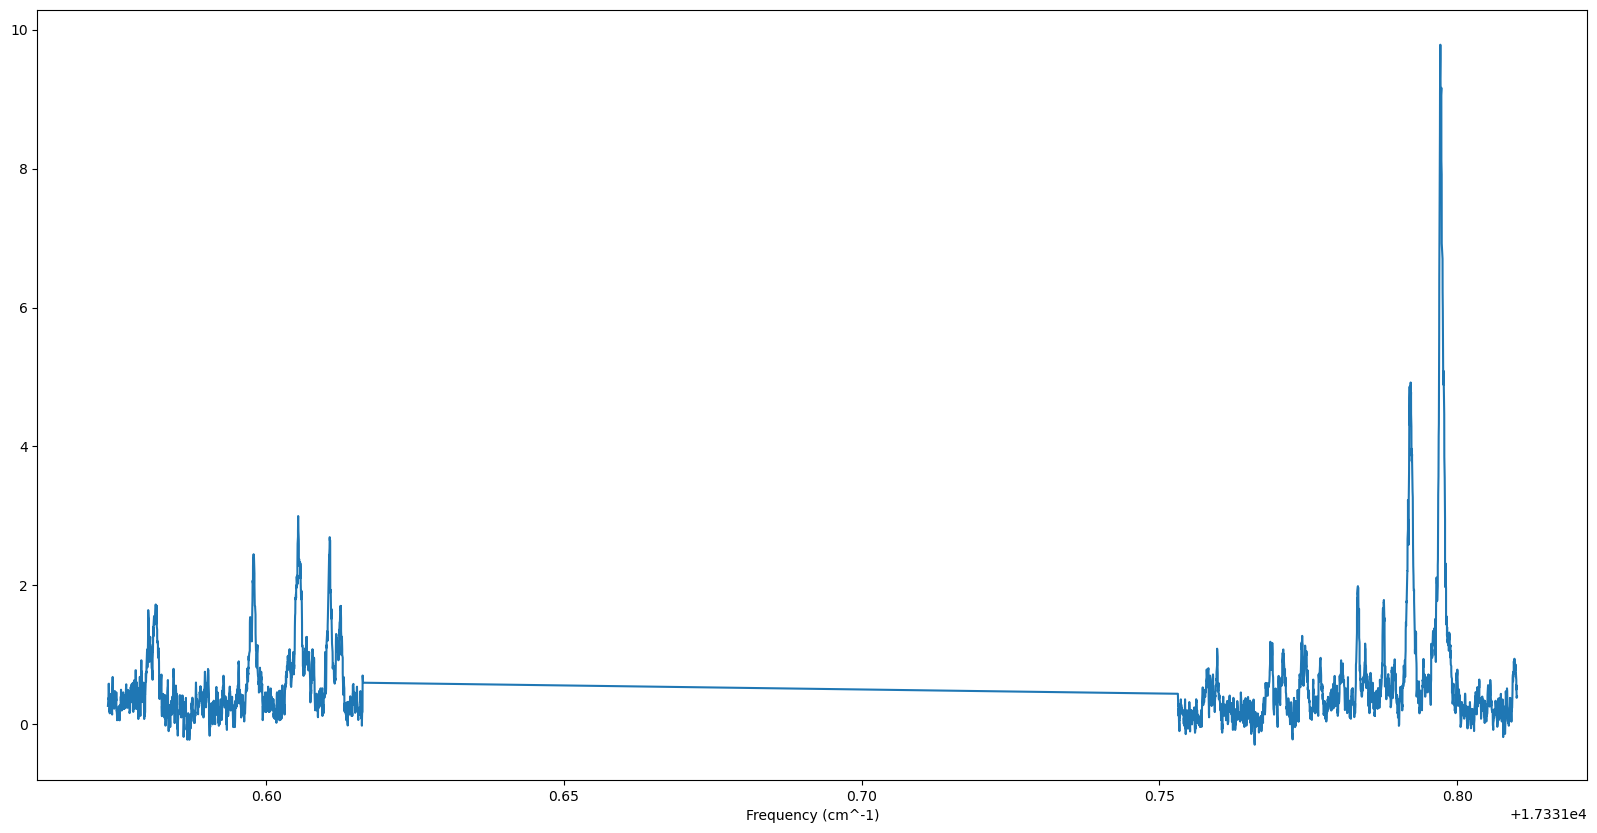

In [7]:
import pandas as pd

df = pd.read_csv("all_scans_sorted.csv")

window = 5
F1_number = "F1=1"

g = df[df["pumping"] == F1_number].sort_values("freq").copy()
frequencies = g["freq"].to_numpy(float)
data = g["signal"].to_numpy(float)
smooth_data = moving_average(data, window)
plt.figure(figsize=(20,10))
plt.xlabel('Frequency (cm^-1)')
plt.plot(frequencies, smooth_data)
plt.show()

In [8]:
#%matplotlib widget
%matplotlib inline

Frequency low to high


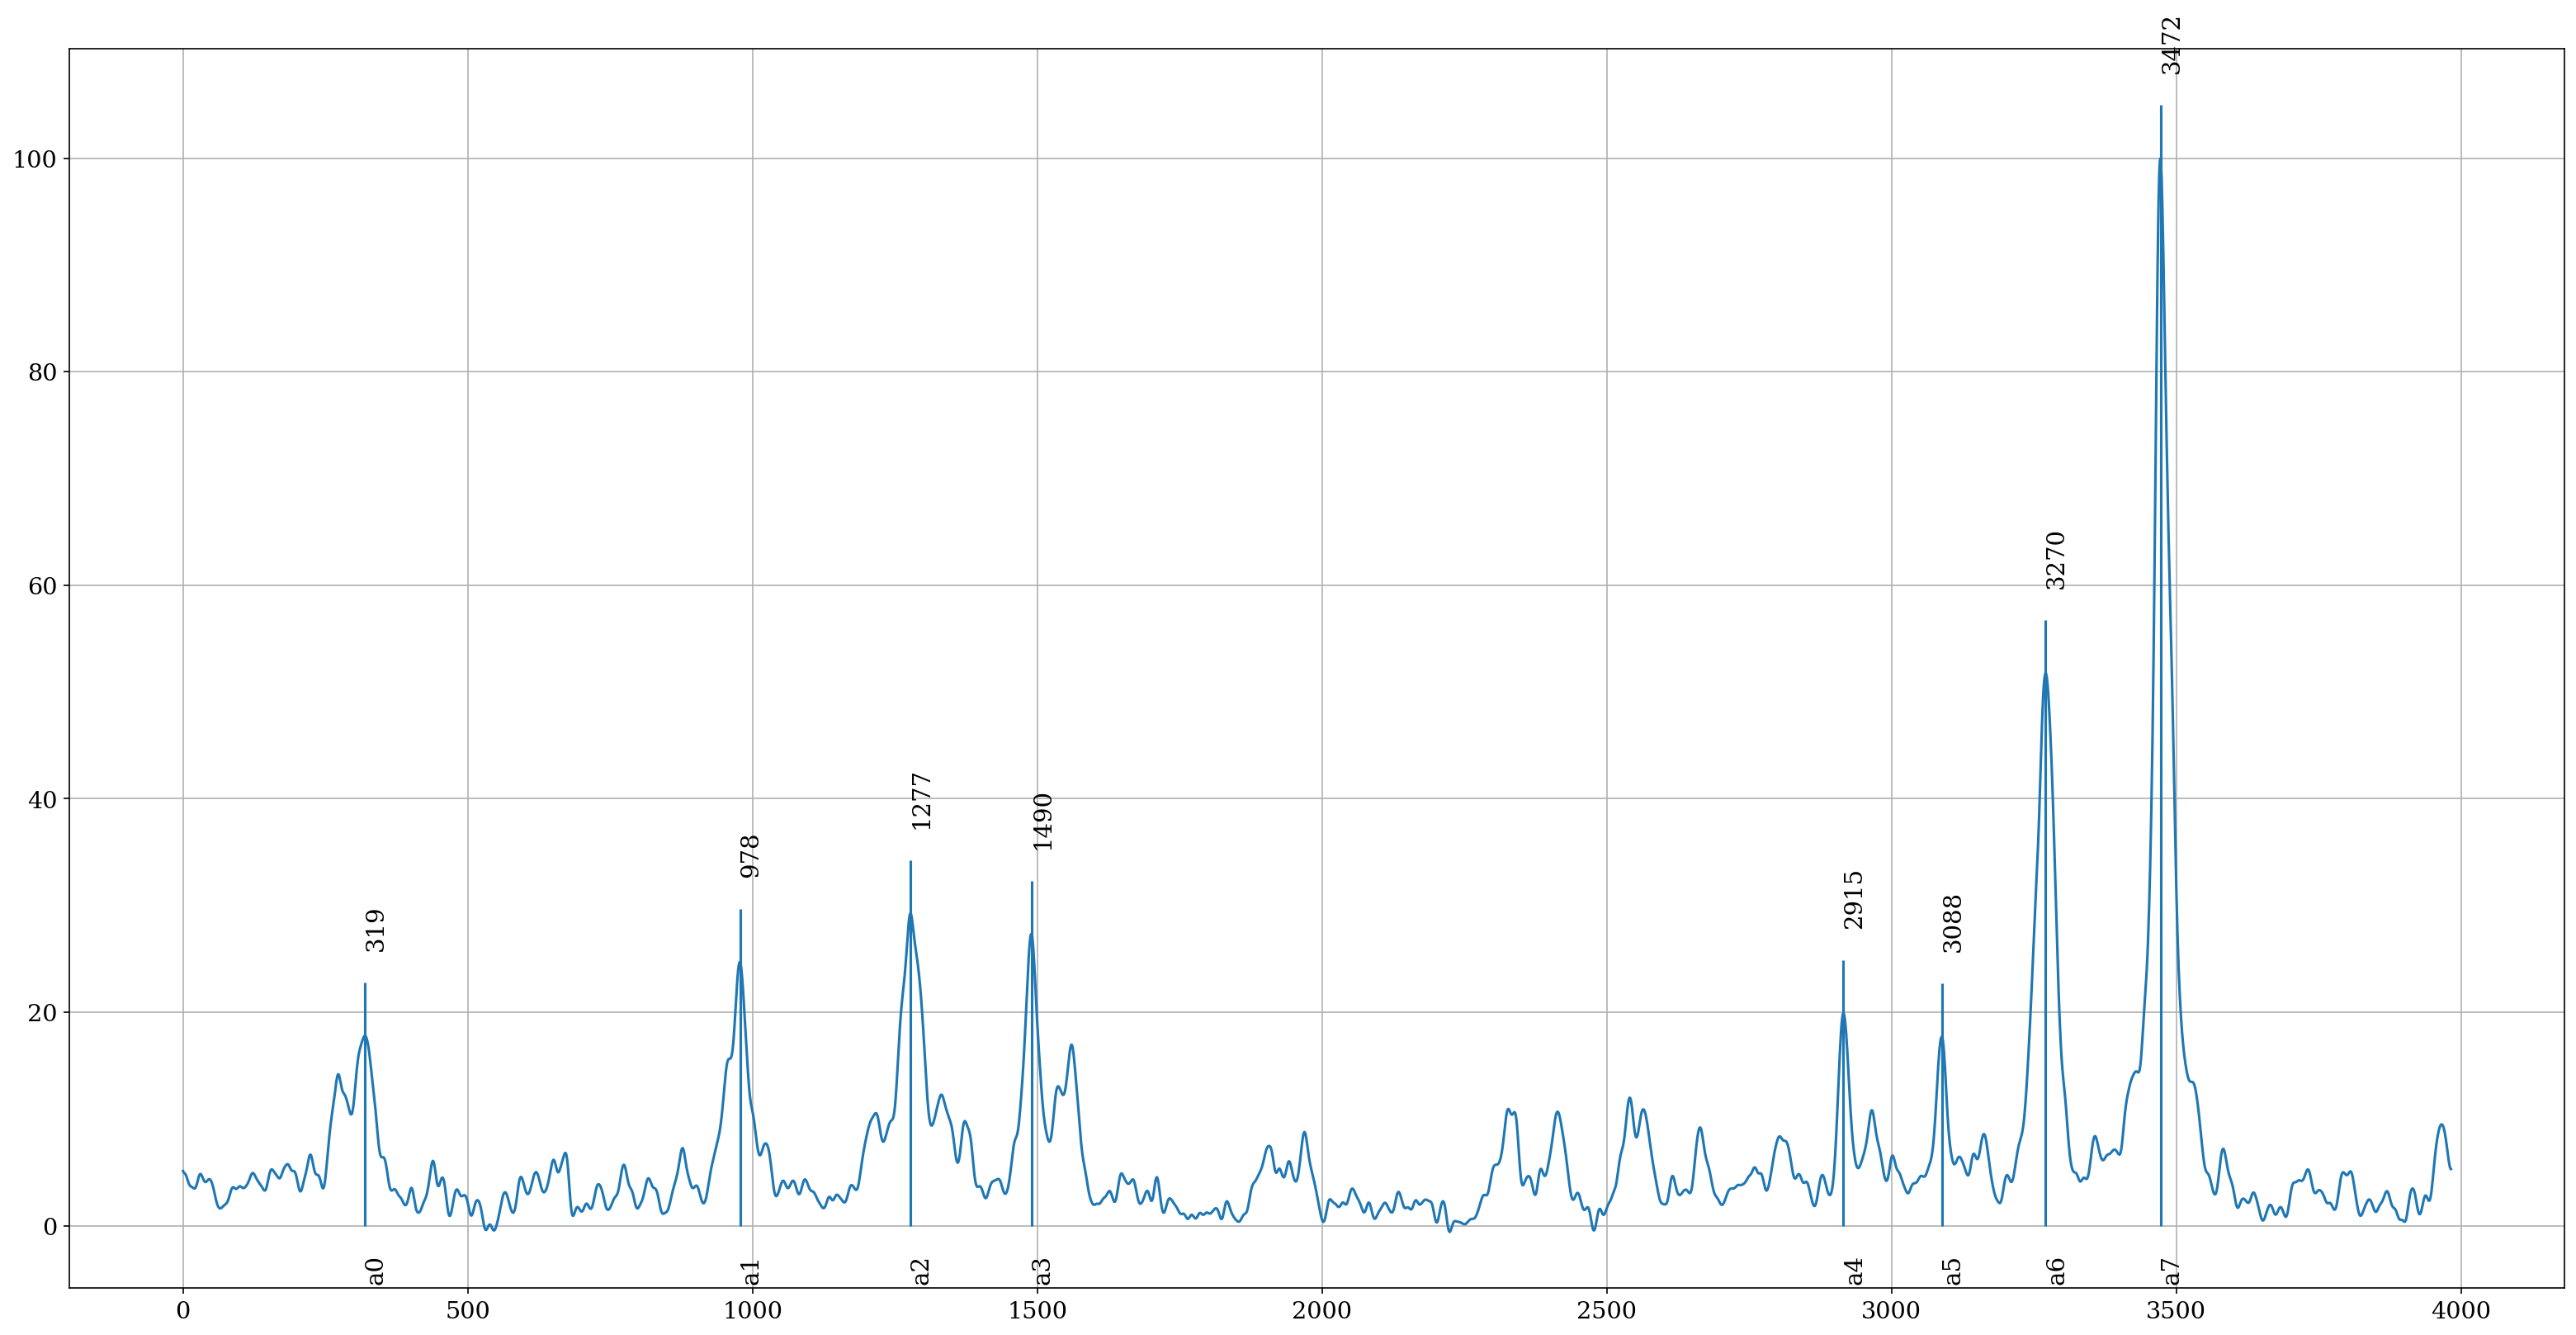

Number of peaks 8


In [10]:

p, p1, width_bound_sigma = Find_Gaussian_initial_guess_lmfit(frequencies,data,0.001,Box=30,threshold=17,add_peak=None, width_bound_sigma = 20)

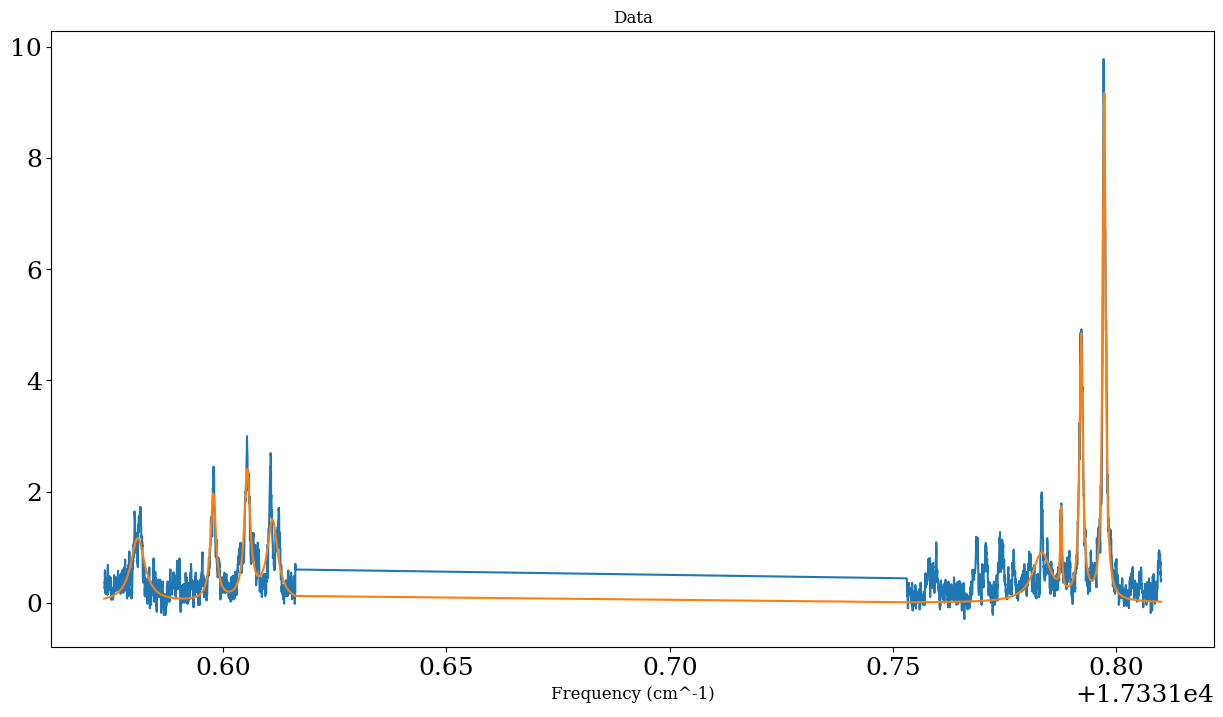

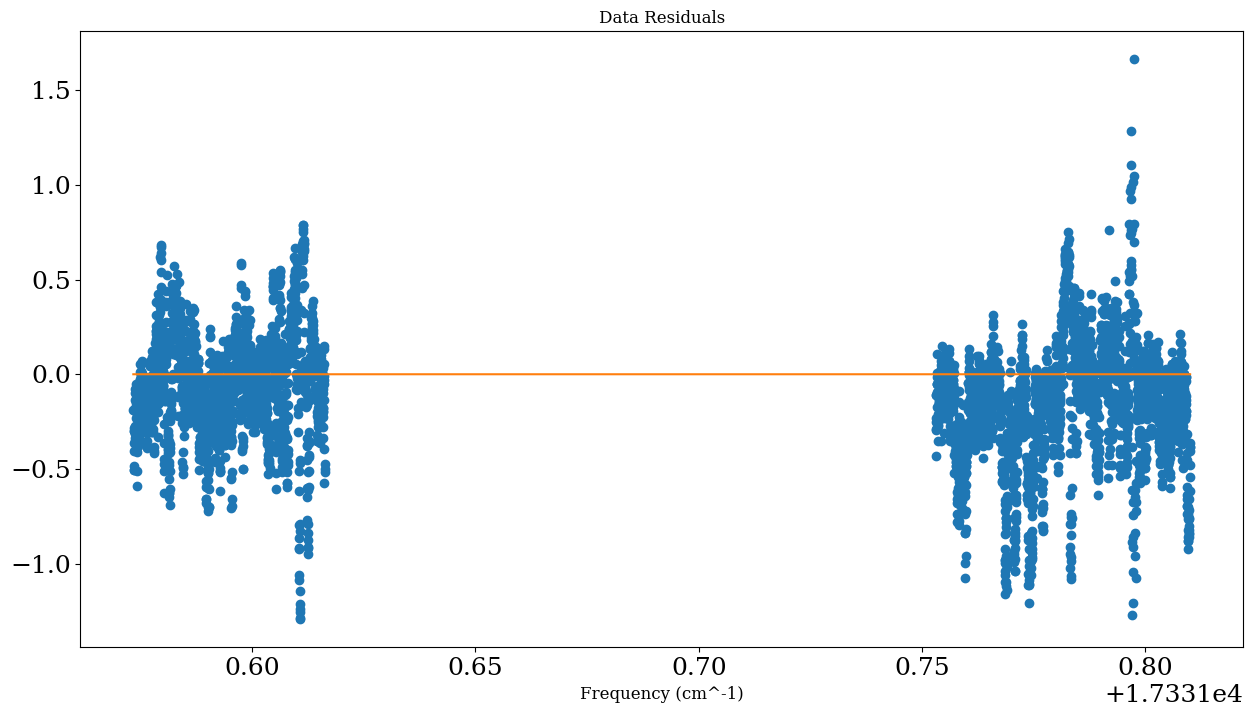

In [11]:
peaks = Gaussian_fit_lmfit_yuiki2(p,p1, width_bound_sigma,frequencies,smooth_data,background_subtract =  False, freq_lim =  None, plot=True, error_estimation=False, Lorentzian_mode = True, print_fit_properties = False)
plt.show()

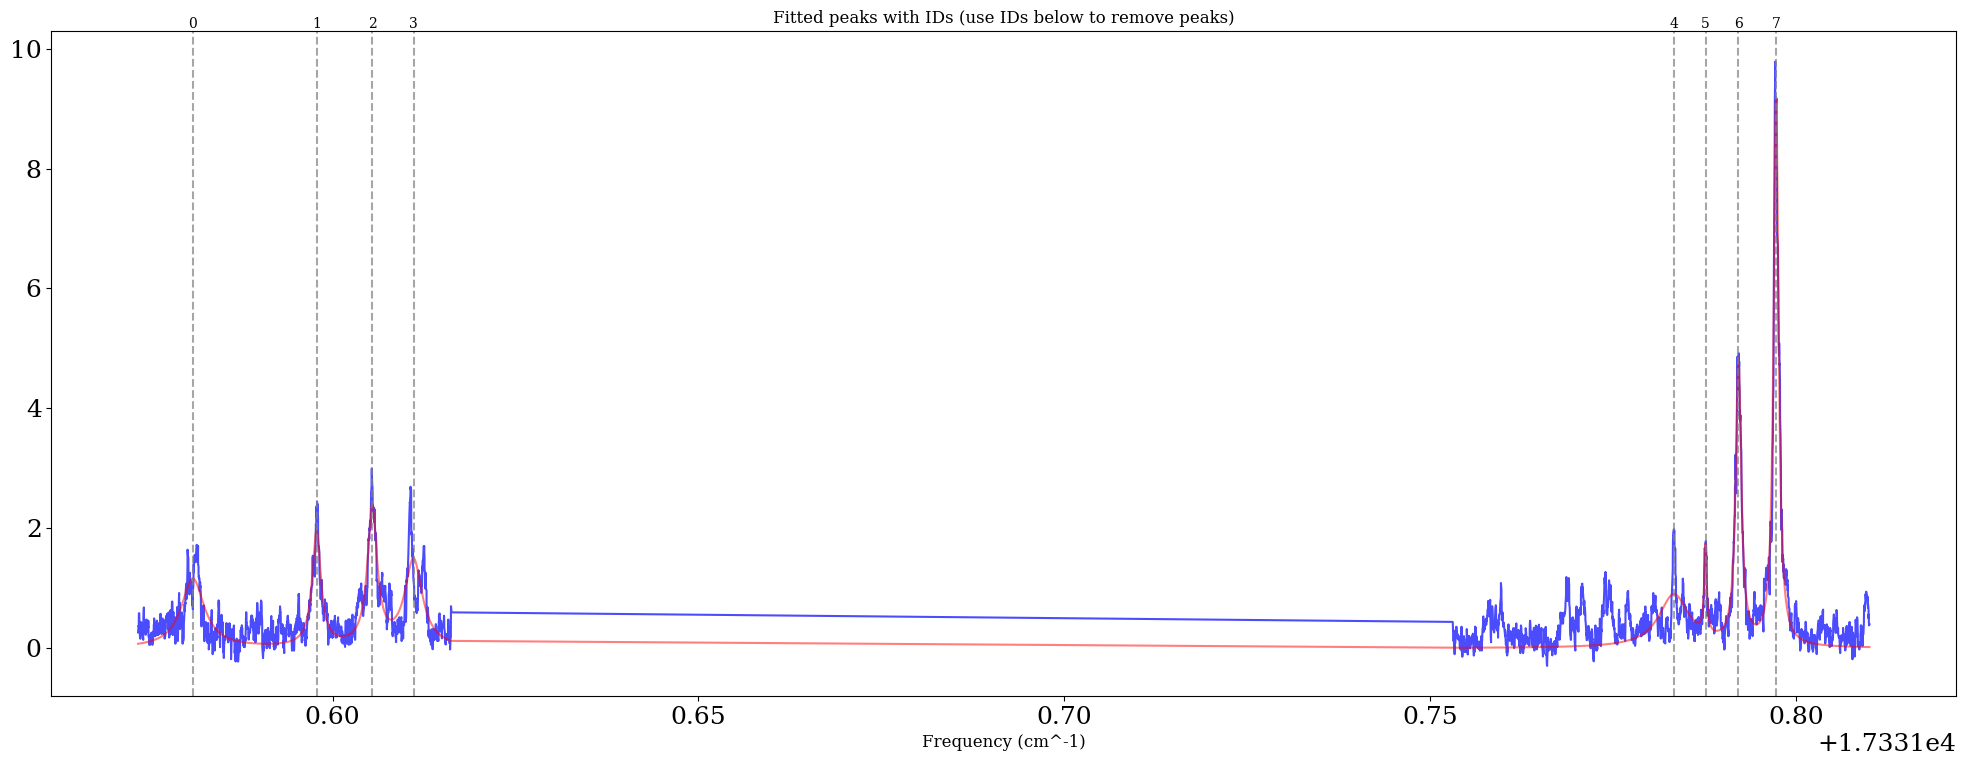

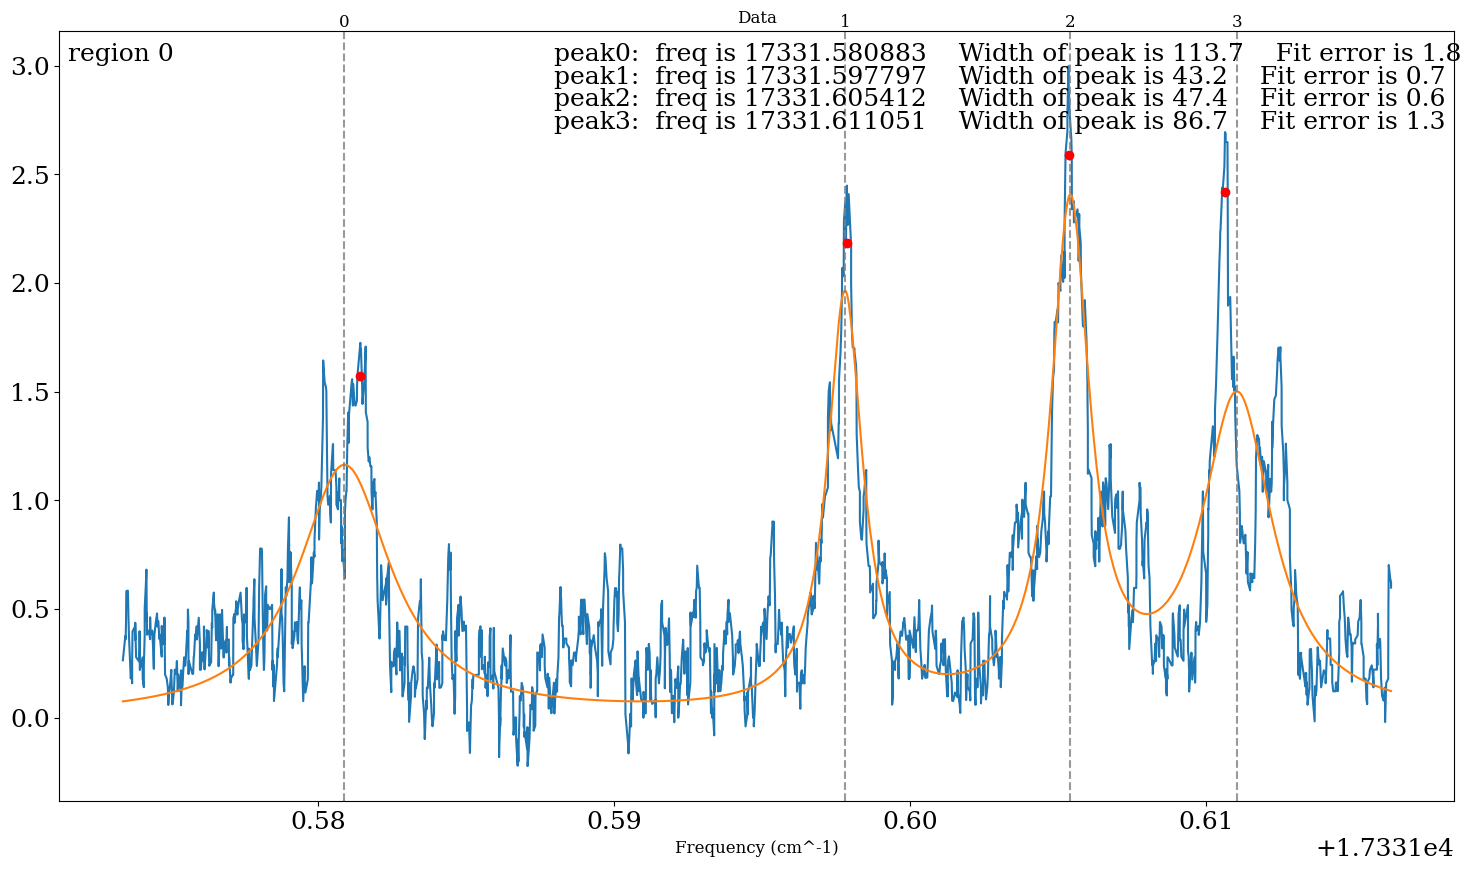

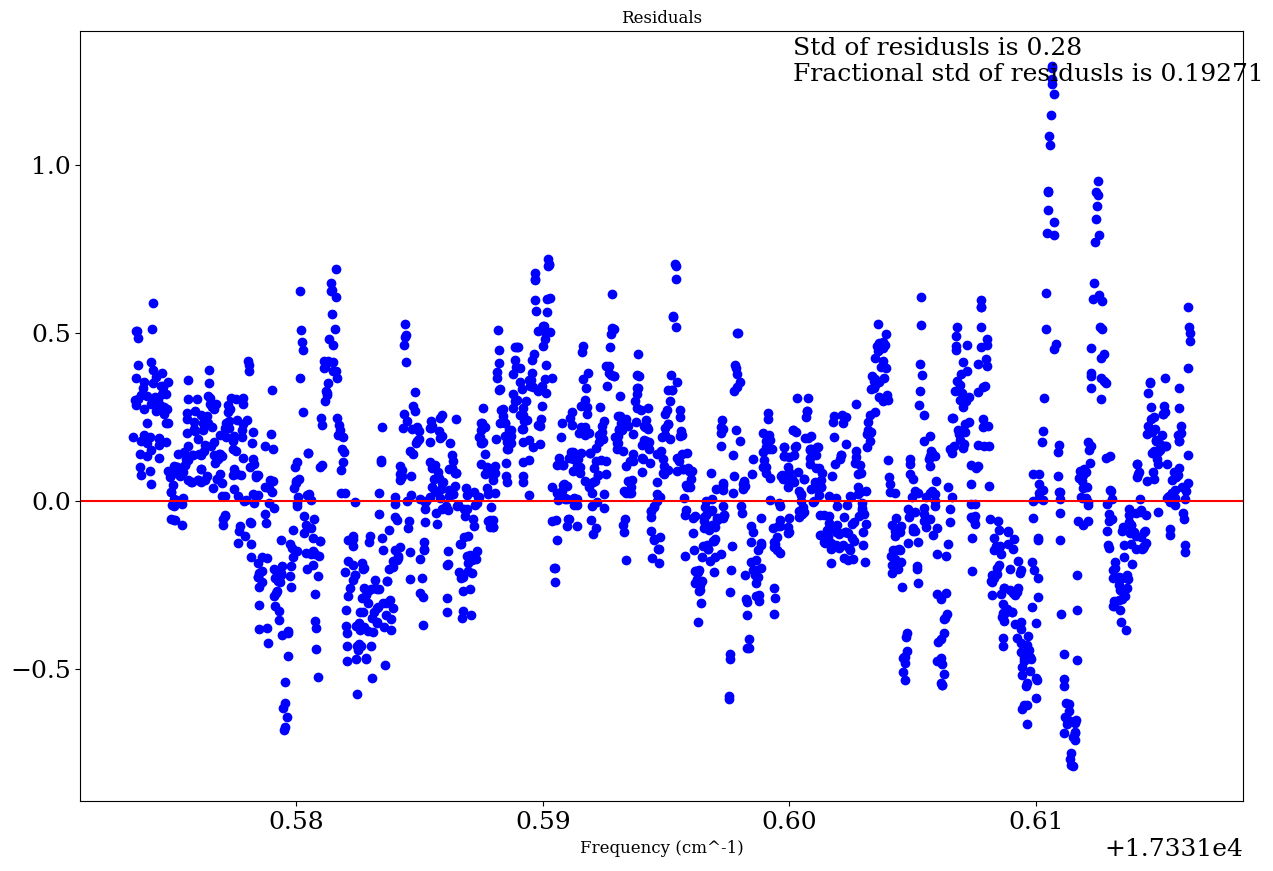

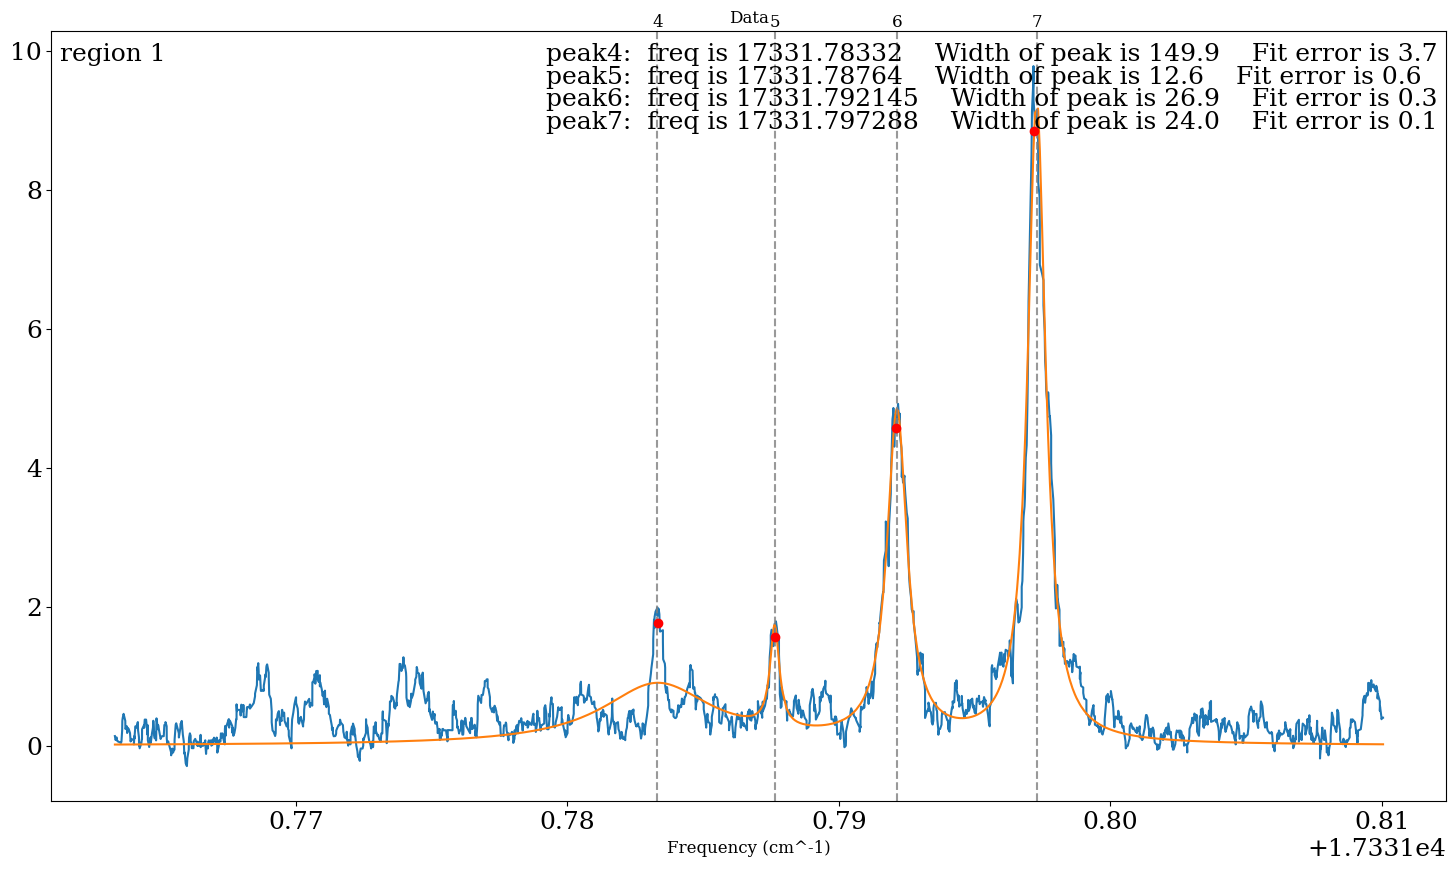

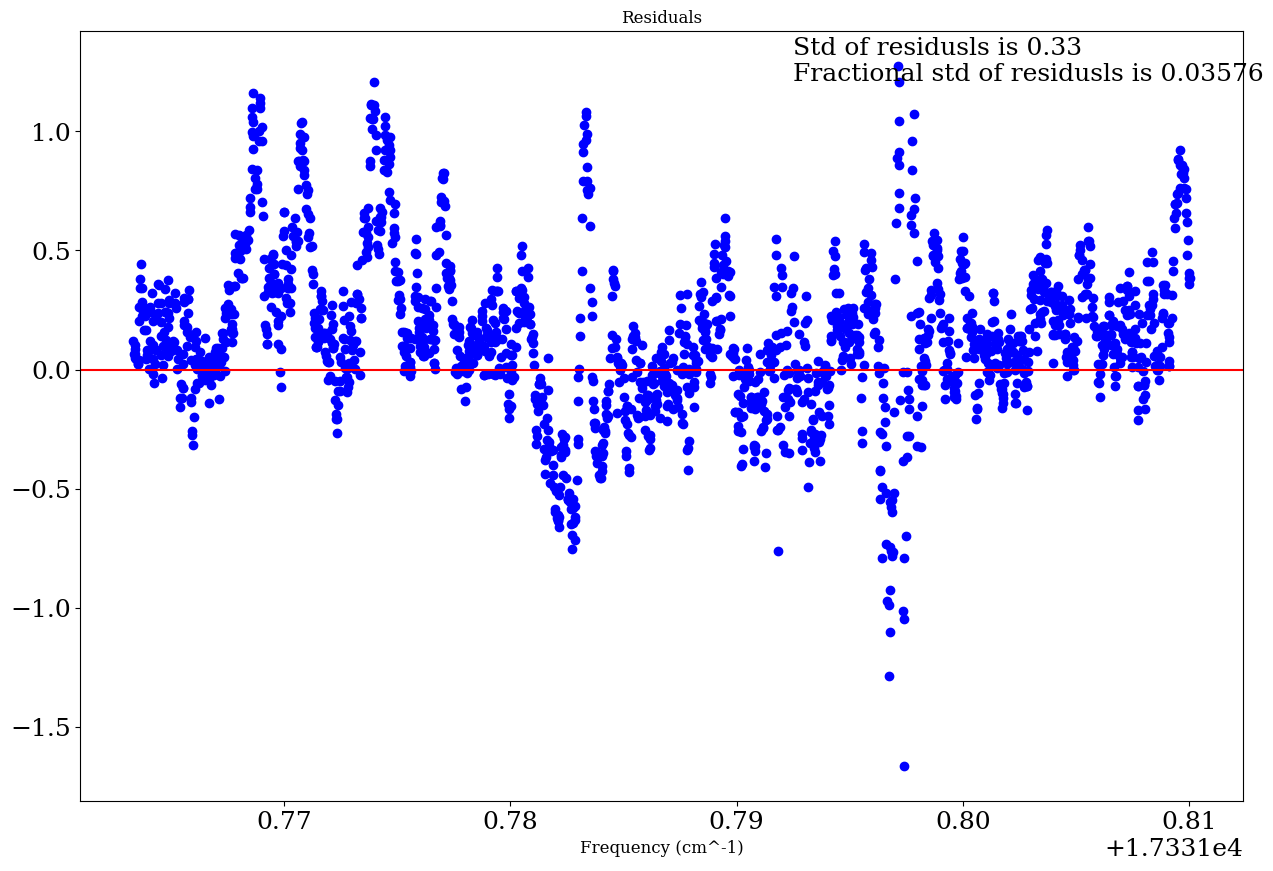

In [12]:
#pp = PdfPages('all_peak_fit_regions_first_round.pdf')

# Overview: full spectrum with vertical dashed lines at fitted peak positions and peak ID annotations
plt.figure(0, figsize=(20, 8))
plt.plot(frequencies, smooth_data, 'b-', alpha=0.7)
plt.plot(frequencies, mult_gaussian(frequencies, peaks[0], peaks[1], peaks[2]), 'r-', alpha=0.5)
ax = plt.gca()
ymin, ymax = ax.get_ylim()
for i in range(len(peaks[0])):
    plt.axvline(peaks[0][i], linestyle='--', color='gray', alpha=0.7)
    plt.text(peaks[0][i], ymax, str(i), ha='center', va='bottom', fontsize=10, rotation=0)
plt.title('Fitted peaks with IDs (use IDs below to remove peaks)', fontsize=12)
plt.xlabel('Frequency (cm^-1)', fontsize=12)
plt.tight_layout()
plt.show()

yboh = 0
for c in range(len(peaks[3])):
    lower_bound = peaks[3][c][0]
    upper_bound = peaks[3][c][1]
    number_of_peaks = peaks[3][c][2]
    remove_index = [i for i , element in enumerate(frequencies) if element > lower_bound and element < upper_bound]
    frequencies_small = [element for i , element in enumerate(frequencies) if i in remove_index]
    smooth_data_small = [element for i , element in enumerate(smooth_data) if i in remove_index]
    fit_data_small = mult_gaussian(frequencies_small,peaks[0],peaks[1],peaks[2])
    
    x = plt.figure(c*10 +1,figsize=(18,10))
    plt.plot(frequencies_small,smooth_data_small)
    plt.plot(frequencies_small,fit_data_small)
    plt.figtext(.13, .85, 'region ' + str(c) )

    # Vertical dashed lines at fitted peak positions with peak ID annotated on top
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    for d in range(number_of_peaks):
        peak_id = yboh + d
        freq = peaks[0][peak_id]
        plt.axvline(freq, linestyle='--', color='gray', alpha=0.8)
        plt.text(freq, ymax, str(peak_id), ha='center', va='bottom', fontsize=12, rotation=0)

    for d in range(number_of_peaks):
        plt.plot(peaks[4][0][yboh],peaks[4][1][yboh], 'ro')
        plt.figtext(.4, .85 - 0.0225*d, 'peak' + str(yboh) + ':  freq is ' +  str(round(peaks[0][yboh],6)) + '    Width of peak is ' + str(round(peaks[1][yboh]*29979.2458,1)) + '    Fit error is ' + str(round(peaks[6][yboh]*29979.2458,1)))

        yboh += 1
        
    plt.title('Data',fontsize=12)
    plt.xlabel('Frequency (cm^-1)',fontsize=12)
    
    resid = smooth_data_small - fit_data_small
    
    y = plt.figure(c*10 +2,figsize=(15,10))
    plt.plot(frequencies_small, resid, 'bo')
    plt.figtext(.60, .83, 'Std of residusls is ' + str(round(resid.std(),2)) + '\nFractional std of residusls is ' + str(round(resid.std()/peaks[2][yboh-1],5)))
    plt.title('Residuals',fontsize=12)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Frequency (cm^-1)',fontsize=12)
    plt.show()
    
    #x.savefig(pp, format='pdf')
    #y.savefig(pp, format='pdf')
    
#pp.close()    


In [13]:
# Manually remove peaks by specifying their IDs (from the plot above)
# Example: peaks_to_remove = [3, 5, 7]  # remove peaks 3, 5, and 7
peaks_to_remove = []  # <-- specify peak IDs to remove, e.g. [2, 4, 9]

keep_indices = [i for i in range(len(peaks[0])) if i not in peaks_to_remove]
peaks_filtered_centers = np.array(peaks[0])[keep_indices]
peaks_filtered_widths = np.array(peaks[1])[keep_indices]
peaks_filtered_heights = np.array(peaks[2])[keep_indices]
peaks_filtered_errors = np.array(peaks[6])[keep_indices]
peaks_filtered_identified = [np.array(peaks[4][0])[keep_indices], np.array(peaks[4][1])[keep_indices]]

# Rebuild cut_regions: count how many kept peaks fall in each region
cut_regions_filtered = []
yboh = 0
keep_set = set(keep_indices)
for c in range(len(peaks[3])):
    lower_bound, upper_bound, number_of_peaks = peaks[3][c][0], peaks[3][c][1], peaks[3][c][2]
    region_indices = list(range(yboh, yboh + number_of_peaks))
    n_kept = sum(1 for i in region_indices if i in keep_set)
    if n_kept > 0:
        cut_regions_filtered.append([lower_bound, upper_bound, n_kept])
    yboh += number_of_peaks

# Build filtered peaks tuple for downstream use (same structure as peaks)
peaks_filtered = (
    peaks_filtered_centers,
    peaks_filtered_widths,
    peaks_filtered_heights,
    cut_regions_filtered,
    peaks_filtered_identified,
    peaks[5],  # caution_centers
    peaks_filtered_errors,
)

print(f'Kept {len(keep_indices)} peaks (removed {len(peaks_to_remove)}: {peaks_to_remove})')
print('Use peaks_filtered instead of peaks for downstream (e.g. Assignments from peak centers)')

Kept 8 peaks (removed 0: [])
Use peaks_filtered instead of peaks for downstream (e.g. Assignments from peak centers)


In [14]:
np.savetxt('peaks_filtered_' + str(F1_number) + '.txt', peaks_filtered[0])
